In [1]:
!pip install psaw

In [1]:
import pandas as pd
import datetime

In [2]:
from psaw import PushshiftAPI
import matplotlib.pyplot as plt 
import nltk
from nltk.corpus import stopwords

In [3]:
from nltk import FreqDist 
import re
import matplotlib.ticker as ticker
import seaborn as sns
import nltk; nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sprihajoshi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
import requests, matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from random import randint
import requests, json, time, datetime
import os

In [5]:
#api = PushshiftAPI()
#start=int(datetime.datetime(2021, 2, 10).timestamp())
#end=int(datetime.datetime(2021, 2, 28).timestamp())

#api_request_generator = api.search_submissions(subreddit='wallstreetbets', after=start, before=end)

In [6]:
#wsb_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

In [7]:
#wsb_submissions.to_csv("posts_retrieved_from_api.csv")

In [8]:
wsb_submissions = pd.read_csv("posts_retrieved_from_api.csv")

/Users/sprihajoshi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (4,68,80,81,82,83) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
wsb_submissions['date'] = pd.to_datetime(wsb_submissions['created_utc'], utc=True, unit='s')

In [10]:
#Tags in WSB
wsb_submissions["link_flair_text"].unique()

array(['Meme', 'Discussion', 'Loss', 'News', 'YOLO', 'Chart', 'Gain',
       'DD', nan, 'Earnings Thread', 'Shitpost', 'Weekend Discussion',
       'Daily Discussion', 'Mods', 'OC'], dtype=object)

In [11]:
DDdata = wsb_submissions[wsb_submissions["link_flair_text"] == "DD"][["id", "title"]]
YOLOdata = wsb_submissions[wsb_submissions["link_flair_text"] == "YOLO"][["id", "title"]]

In [12]:
tickers = pd.read_csv("tickers.csv")

In [13]:
tickers_dict = dict()

for _ in range(len(tickers)):
    tickers_dict[tickers.iloc[_, 0]] = tickers.iloc[_, 1]

In [14]:
def remove_stopword(listt):
    return [word for word in listt if word.lower() not in stopwords.words('english')]

def clean(series):
    #Look for tickers and keep them caps, make the rest small
    #remove stopwords
    #remove punctuation marks
    #remove DD, Yolo, YOLO 
    s=[]
    
    for index, title in series.iteritems():
        
        #Remove punctuations
        title = re.sub(r'[^\w\s]', '', title) 
        
        #Tokenize
        title_into_words = title.split()
        
        #Remove stopwords
        title_wo_sw = remove_stopword(title_into_words)
        
        if "DD" in title_wo_sw:
            title_wo_sw.remove("DD")
        if "YOLO" in title_wo_sw:
            title_wo_sw.remove("YOLO")
        if "Yolo" in title_wo_sw:
            title_wo_sw.remove("Yolo")
        
        new_list = []
        
        for word in title_wo_sw:
            if word not in tickers_dict.keys():
                new_list.append(word.lower()) 
            else:
                new_list.append(word.upper())
                    
        #print(title_wo_sw)
        s.append(new_list)
        
    return s

In [15]:
DDdata["Tokenized"] = clean(DDdata["title"])
YOLOdata["Tokenized"] = clean(YOLOdata["title"])

In [16]:
DDdata[["title","Tokenized"]].head()

,title,Tokenized
23,Using Covered Calls to Buy Volatile Stocks like GEE EM EE at a Steep Discount,"[using, covered, calls, buy, volatile, stocks, like, gee, em, ee, steep, discount]"
93,Meme stock price target,"[meme, stock, price, target]"
116,Cryptography DD,[cryptography]
150,This is...,[]
165,"I see a lot of memes about AMC and other stocks, but there is only GME !","[see, lot, memes, AMC, stocks, GME]"


In [17]:
YOLOdata[["title","Tokenized"]].head()

,title,Tokenized
8,Hot wheels unleashed and the buying power of spoiled children.,"[hot, wheels, unleashed, buying, power, spoiled, children]"
16,Stimulus,[stimulus]
24,If I make this shot all your stocks go green,"[make, shot, stocks, go, green]"
25,"GME Yolo ¯\_(ツ)_/¯ it ain’t much, but it’s honest work 🚀🚀🙌💎🙌","[GME, _ツ_, aint, much, honest, work]"
48,"LWSB: Lucid Wall Street bets, all longs - Lucid Stock is heavily shorted by coordinated groups and manipulators. Why can’t we have a LWSB and defend. Are you IN? Credits to u/Madmax212121","[lwsb, lucid, wall, street, bets, longs, lucid, stock, heavily, shorted, coordinated, groups, manipulators, cant, lwsb, defend, credits, umadmax212121]"


In [18]:
def getCount(data):
    ticker_count = FreqDist()
    for listt in data.Tokenized:
        for word in listt:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
    return ticker_count

In [19]:
def todf(ticker_count):
    df = pd.DataFrame.from_dict(ticker_count, orient='index')
    df.columns = ['Frequency']
    df.index.name = 'Ticker'
    df.sort_values(by="Frequency", ascending=False, inplace=True)
    df.reset_index(inplace=True)
    return df

In [20]:
DDdata_count = getCount(DDdata)
YOLOdata_count = getCount(YOLOdata)

In [21]:
DDdf = todf(DDdata_count)
YOLOdf = todf(YOLOdata_count)

In [22]:
DDdf.head(10) 

,Ticker,Frequency
0,GME,549
1,AMC,234
2,SNDL,168
3,SOS,99
4,PLTR,94
5,TLRY,81
6,RKT,58
7,EV,55
8,APHA,50
9,BB,46


In [23]:
[tickers_dict.get(ticker) for ticker in DDdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'SOS Limited American Depositary Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Rocket Companies Inc. Class A Common Stock',
 'Eaton Vance Corporation Common Stock',
 'Aphria Inc. Common Shares',
 'BlackBerry Limited Common Stock']

In [24]:
YOLOdf.head(10)

,Ticker,Frequency
0,GME,1564
1,AMC,1196
2,SNDL,544
3,PLTR,269
4,TLRY,120
5,CCIV,112
6,NOK,98
7,GO,97
8,SOS,90
9,CTRM,83


In [25]:
[tickers_dict.get(ticker) for ticker in YOLOdf.Ticker.head(10) if ticker in tickers_dict.keys()]

['GameStop Corporation Common Stock',
 'AMC Entertainment Holdings Inc. Class A Common Stock',
 'Sundial Growers Inc. Common Shares',
 'Palantir Technologies Inc. Class A Common Stock',
 'Tilray Inc. Class 2 Common Stock',
 'Churchill Capital Corp IV Class A Common Stock',
 'Nokia Corporation Sponsored American Depositary Shares',
 'Grocery Outlet Holding Corp. Common Stock',
 'SOS Limited American Depositary Shares',
 'Castor Maritime Inc. Common Shares']

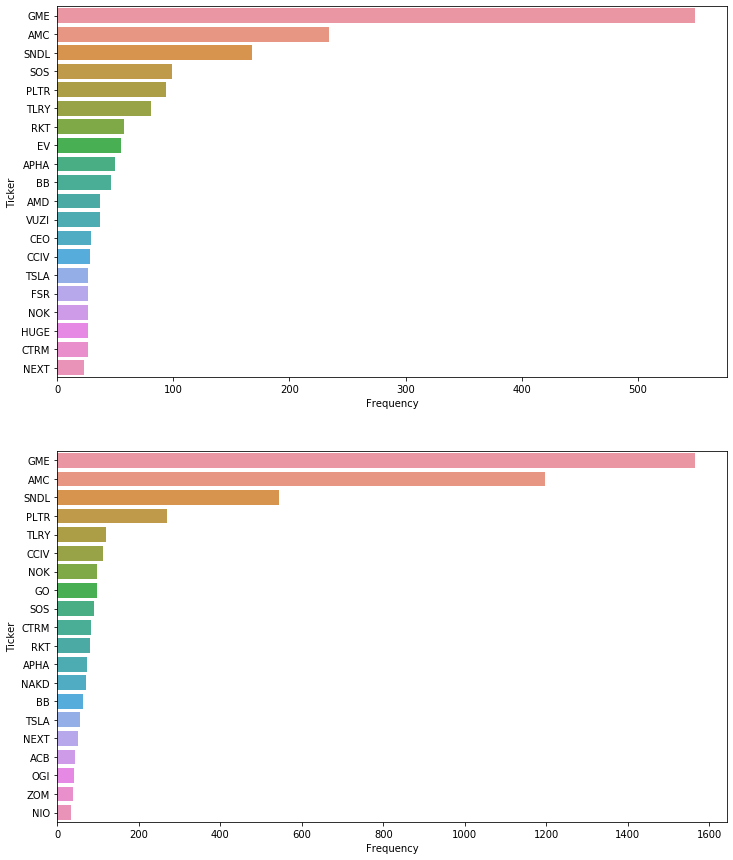

In [26]:
fig, ax = plt.subplots(2, figsize=(12,15))
sns.barplot(y='Ticker', x='Frequency', data=DDdf.head(20), ax=ax[0])
sns.barplot(y='Ticker', x='Frequency', data=YOLOdf.head(20), ax=ax[1])

## Sentiment towards top 10 tickers

In [ ]:
def fetch_comments(submission_id):
    fields = ["body","id","link_id","parent_id"]
    allcomments = requests.get("https://api.pushshift.io/reddit/comment/search/?submission_id="+submission_id)
    if not allcomments.status_code==200:
        print('Unable to perform request with status code: ' + str(allcomments.status_code))
        return pd.DataFrame(columns=fields)
    else:
        comment_ids = getComment_id(allcomments)
        filtered_comments = requests.get("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id"+"&size="+str(min(len(comment_ids),50)))
        #print("https://api.pushshift.io/reddit/comment/search?ids="+comment_ids+"&fields=body,id,link_id,parent_id")
        if not filtered_comments.status_code==200:
            print('Unable to perform request with status code: ' + str(filtered_comments.status_code))
            return pd.DataFrame(columns=fields)
        else: 
            return pd.DataFrame(json.loads(filtered_comments.text)["data"])

def getComment_id(result):
    s=""
    for dicti in json.loads(result.text)["data"]:
        s+=dicti.get("id")+","
    return s[:-1]

In [47]:
def comments_toSeries(data):
    return [fetch_comments(submission_id=data.iloc[i]['id']) for i in range(data.shape[0])]

In [216]:
commentsDD = pd.read_csv("DDsubmissions.csv")

In [217]:
commentsYOLO = pd.read_csv("YOLOsubmissions.csv")

In [218]:
commentsDD.drop(commentsDD.columns[0], axis=1, inplace=True)
commentsDD['date'] = pd.to_datetime(commentsDD['utc'], utc=True, unit='s')

commentsYOLO.drop(commentsYOLO.columns[0], axis=1, inplace=True)
commentsYOLO['date'] = pd.to_datetime(commentsYOLO['utc'], utc=True, unit='s')

In [219]:
commentsDD = commentsDD[commentsDD["date"]>=min(commentsDD["date"])]
commentsDD = commentsDD[commentsDD["date"]<=min(commentsDD["date"]) + datetime.timedelta(days=18)]

commentsYOLO = commentsYOLO[commentsYOLO["date"]>=min(commentsYOLO["date"])]
commentsYOLO = commentsYOLO[commentsYOLO["date"]<=min(commentsYOLO["date"]) + datetime.timedelta(days=18)]

In [221]:
commentsDD.shape, commentsYOLO.shape

((27840, 8), (27519, 8))

In [222]:
commentsDD["Tokenized"] = clean(commentsDD["body"])
commentsDD["Tokenized_joined"] = commentsDD["Tokenized"].apply(lambda x: ' '.join(x))

In [223]:
commentsYOLO["Tokenized"] = clean(commentsYOLO["body"])
commentsYOLO["Tokenized_joined"] = commentsYOLO["Tokenized"].apply(lambda x: ' '.join(x))

In [228]:
commentsDD.to_csv("cleanedDDcomments.csv")
commentsYOLO.to_csv("cleanedYOLOcomments.csv")

In [224]:
commentsDD.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb4d,Another downside is that the stock plummets and you’re left holding stock that has lost more than your premium was. Which is likely and why the premiums are so high due to that volatility.\n\nI hold 17 GME @320 btw.,gp3h2a6,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614468e+09,2021-02-27 23:16:23+00:00,"[another, downside, stock, plummets, youre, left, holding, stock, lost, premium, likely, premiums, high, due, volatility, hold, 17, GME, 320, btw]",another downside stock plummets youre left holding stock lost premium likely premiums high due volatility hold 17 GME 320 btw
1,ltzb4d,"Exactly what I've wanted to do but don't have the bankroll to buy 100 shares at these prices. I agree with everything you said, weirdly non-retarded for this sub.",gp3dj89,t3_ltzb4d,t3_ltzb4d,wallstreetbets,1.614467e+09,2021-02-27 22:55:21+00:00,"[exactly, ive, wanted, dont, bankroll, buy, 100, shares, prices, agree, everything, said, weirdly, nonretarded, sub]",exactly ive wanted dont bankroll buy 100 shares prices agree everything said weirdly nonretarded sub


In [225]:
commentsYOLO.head(2)

,sub_id,body,id,link_id,parent_id,subreddit,utc,date,Tokenized,Tokenized_joined
0,ltzb06,Wtf is this shit normie. Why slow down a video? You do know people here have autism and adhd? Speed this up.get to your point.,gp3dfmy,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614466e+09,2021-02-27 22:54:46+00:00,"[wtf, shit, normie, slow, video, know, people, autism, adhd, speed, upget, point]",wtf shit normie slow video know people autism adhd speed upget point
1,ltzb06,🥶,gp3gdal,t3_ltzb06,t3_ltzb06,wallstreetbets,1.614468e+09,2021-02-27 23:11:46+00:00,[],


In [226]:
def getSentiments(series):
    sentiment_label=[]
    for comment in series:
        model = SentimentIntensityAnalyzer()
        sentiment = model.polarity_scores(comment)
        positive, neutral, negative = sentiment['pos'], sentiment['neu'], sentiment['neg']
        
        if comment=="":
            sentiment_label.append("neutral "+str(neutral))
        else:
            if max(positive,neutral,negative) == positive:
                sentiment_label.append("positive "+str(positive))
            elif max(positive,neutral,negative) == negative:
                sentiment_label.append("negative "+str(negative))
            else: 
                sentiment_label.append("neutral "+str(neutral))
        #print(comment," : ",sentiment_label)
        #print(len(sentiment_label),"/",len(series))
        
    return sentiment_label

In [248]:
def getTickerofthecomment(series):
    tickerincomment = []
    for comment in series:
        #print(comment)
        ticker_count = FreqDist()
        for word in comment:
            if word in tickers_dict.keys():
                ticker_count[word] += 1
        ticker_count = dict(ticker_count)
        if len(ticker_count)==0:
            tickerincomment.append(None)
        elif len(ticker_count)==1:
            tickerincomment.append(list(ticker_count.keys())[0])
        else:
            tickerincomment.append(max(ticker_count, key=ticker_count.get))
        #print(len(tickerincomment),"/",len(series))
    return tickerincomment

In [272]:
commentsDD["comment_sentiment"] = getSentiments(commentsDD["Tokenized_joined"])

In [249]:
commentsDD["comment_ticker"] = getTickerofthecomment(commentsDD["Tokenized"])

In [273]:
commentsYOLO["comment_sentiment"] = getSentiments(commentsYOLO["Tokenized_joined"])

In [250]:
commentsYOLO["comment_ticker"] = getTickerofthecomment(commentsYOLO["Tokenized"])

In [303]:
commentsYOLO = pd.read_csv("YOLOcomments_Sentiments_beforescore.csv")
commentsDD = pd.read_csv("DDcomments_Sentiments_beforescore.csv")

In [307]:
commentsDD.drop(commentsDD.columns[[0,13]], axis=1, inplace=True)

In [305]:
commentsYOLO[['comment_sentiment','sentiment_score']] = commentsYOLO['comment_sentiment'].str.split(' ', expand=True)

In [308]:
commentsDD[['comment_sentiment','sentiment_score']] = commentsDD['comment_sentiment'].str.split(' ', expand=True)

In [309]:
commentsDD[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].head(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
0,Another downside is that the stock plummets and you’re left holding stock that has lost more than your premium was. Which is likely and why the premiums are so high due to that volatility.\n\nI hold 17 GME @320 btw.,"['another', 'downside', 'stock', 'plummets', 'youre', 'left', 'holding', 'stock', 'lost', 'premium', 'likely', 'premiums', 'high', 'due', 'volatility', 'hold', '17', 'GME', '320', 'btw']",neutral,GME,0.807
1,"Exactly what I've wanted to do but don't have the bankroll to buy 100 shares at these prices. I agree with everything you said, weirdly non-retarded for this sub.","['exactly', 'ive', 'wanted', 'dont', 'bankroll', 'buy', '100', 'shares', 'prices', 'agree', 'everything', 'said', 'weirdly', 'nonretarded', 'sub']",neutral,NaN,0.635


In [306]:
commentsYOLO[["body","Tokenized","comment_sentiment", "comment_ticker", "sentiment_score"]].tail(2)

,body,Tokenized,comment_sentiment,comment_ticker,sentiment_score
27517,"The YOLO flair exists for the highest stakes, highest risk, plays. We're talking $25K+ on OTM options that expire this week. Your post will be removed and you may be banned if you post some low energy plays.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*","['flair', 'exists', 'highest', 'stakes', 'highest', 'risk', 'plays', 'talking', '25k', 'otm', 'options', 'expire', 'week', 'post', 'removed', 'may', 'banned', 'post', 'low', 'energy', 'plays', 'bot', 'action', 'performed', 'automatically', 'please', 'contact', 'moderators', 'subredditmessagecomposetorwallstreetbets', 'questions', 'concerns']",neutral,NaN,0.606
27518,"The YOLO flair exists for the highest stakes, highest risk, plays. We're talking $25K+ on OTM options that expire this week. Your post will be removed and you may be banned if you post some low energy plays.\n\n*I am a bot, and this action was performed automatically. Please [contact the moderators of this subreddit](/message/compose/?to=/r/wallstreetbets) if you have any questions or concerns.*","['flair', 'exists', 'highest', 'stakes', 'highest', 'risk', 'plays', 'talking', '25k', 'otm', 'options', 'expire', 'week', 'post', 'removed', 'may', 'banned', 'post', 'low', 'energy', 'plays', 'bot', 'action', 'performed', 'automatically', 'please', 'contact', 'moderators', 'subredditmessagecomposetorwallstreetbets', 'questions', 'concerns']",neutral,NaN,0.606


In [275]:
commentsYOLO.to_csv("YOLOcomments_Sentiments_beforescore.csv")
commentsDD.to_csv("DDcomments_Sentiments_beforescore.csv")

In [311]:
commentsYOLO["sentiment_score"] = commentsYOLO["sentiment_score"].astype(float)
commentsDD["sentiment_score"] = commentsDD["sentiment_score"].astype(float)

In [345]:
def sentAnalysis(data, ddf):
    sentiments_perticker = dict()
    for popticker in ddf.head(10)["Ticker"]:
        pos = 0
        neg = 0
        neu = 0
        df = data[data["comment_ticker"]==popticker]
        total = len(df)
        for senti,score in zip(df["comment_sentiment"],df["sentiment_score"]):
            if senti=="positive":
                pos+=score
            if senti=="negative":
                neg+=score
            if senti=="neutral":
                neu+=score
        sentiments_perticker[popticker] = [(pos/total),(neg/total),(neu/total)]
    return sentiments_perticker

In [346]:
DDsentiments_perticker = pd.DataFrame(sentAnalysis(commentsDD, DDdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [347]:
YOLOsentiments_perticker = pd.DataFrame(sentAnalysis(commentsYOLO, YOLOdf), index=["Positive", "Negative", "Neutral"]).transpose()

In [348]:
YOLOsentiments_perticker

,Positive,Negative,Neutral
GME,0.028113,0.020966,0.689117
AMC,0.043607,0.012442,0.748236
SNDL,0.032900,0.013600,0.752833
PLTR,0.042967,0.011577,0.698893
TLRY,0.000000,0.000000,0.842923
CCIV,0.085333,0.000000,0.572000
NOK,0.071235,0.030265,0.732735
GO,0.019714,0.019357,0.828143
SOS,0.051250,0.000000,0.764417
CTRM,0.000000,0.000000,1.000000


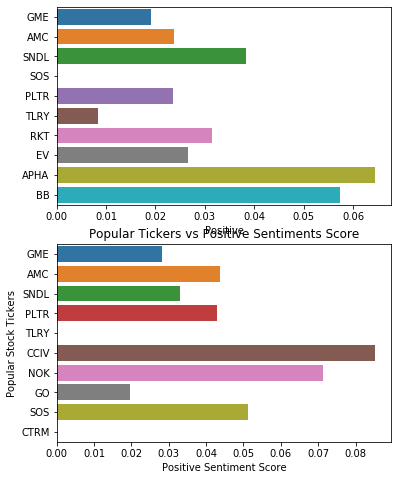

In [354]:
fig, ax = plt.subplots(2, figsize=(6,8))
sns.barplot(y=DDsentiments_perticker.index, x='Positive', data=DDsentiments_perticker, ax=ax[0])
sns.barplot(y=YOLOsentiments_perticker.index, x='Positive', data=YOLOsentiments_perticker, ax=ax[1])

plt.title('Popular Tickers vs Positive Sentiments Score')
plt.xlabel('Positive Sentiment Score')
plt.ylabel('Popular Stock Tickers')
plt.show()